<a href="https://colab.research.google.com/github/Priyanka-code-sys/Thesis_Priyanka/blob/main/cnn_lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
import sklearn
import matplotlib.pyplot as plt

In [2]:
#set the memory growth for the gpu
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu,True)

In [3]:
#define the mirror stragy to use all gpus
strategy = tf.distribute.MirroredStrategy(["GPU:0", "GPU:1"])

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


In [4]:
!wget https://s3.amazonaws.com/amazon-reviews-pds/tsv/amazon_reviews_multilingual_UK_v1_00.tsv.gz
!wget https://s3.amazonaws.com/amazon-reviews-pds/tsv/amazon_reviews_multilingual_FR_v1_00.tsv.gz

--2021-12-15 17:00:28--  https://s3.amazonaws.com/amazon-reviews-pds/tsv/amazon_reviews_multilingual_UK_v1_00.tsv.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.160.120
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.160.120|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 349370868 (333M) [application/x-gzip]
Saving to: ‘amazon_reviews_multilingual_UK_v1_00.tsv.gz’

amazon_reviews_mult 100%[===================>] 333.19M  33.8MB/s    in 10s     

2021-12-15 17:00:39 (32.2 MB/s) - ‘amazon_reviews_multilingual_UK_v1_00.tsv.gz’ saved [349370868/349370868]

--2021-12-15 17:00:39--  https://s3.amazonaws.com/amazon-reviews-pds/tsv/amazon_reviews_multilingual_FR_v1_00.tsv.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.140.128
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.140.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70583516 (67M) [application/x-gzip]
Saving to: ‘amazon_reviews_multilingua

In [5]:
#load the pandas dataframe
#load the pandas dataframe
df_en = pd.read_csv('amazon_reviews_multilingual_UK_v1_00.tsv.gz',delimiter = '\t', quoting = 3)
df_fr = pd.read_csv('amazon_reviews_multilingual_FR_v1_00.tsv.gz',delimiter = '\t', quoting = 3)

In [6]:
#remove the un-necessary rows and columns
df_en = df_en.loc[:,['review_headline','review_body','star_rating']]
df_fr = df_fr.loc[:,['review_headline','review_body','star_rating']]


In [7]:
#find the length of both the datasets
print(len(df_en.index))
print(len(df_fr.index))

1707494
254080


In [8]:
#take 250k review from each dataset (to balance english and french dataset)
df_en = sklearn.utils.shuffle(df_en)
df_en = df_en[:250000]
df_fr = sklearn.utils.shuffle(df_fr)
df_fr = df_fr[:250000]

In [9]:
#combine the dataset into single dataset
df = pd.concat([df_en,df_fr])

In [10]:
df.head(5)

,review_headline,review_body,star_rating
1033494,So Good At Being Bad,Waiting for the postman to arrive this morning...,5
328998,Different but fun!,Not a book I knew anything about but became ho...,4
1268797,Very usefull for streaming full HD video to my...,No problems for watching movies over 7GB and f...,1
934205,A magnificent collection of songs,A magnificent album from Elbow. It is full of ...,5
1468667,Band Of Brothers - A personal view,Lets cut straight to the chase here. HBOs Band...,5


In [11]:
df.tail(5)

,review_headline,review_body,star_rating
207653,Star Trek Les films,Coffret réunissant les 10 films de star trek q...,4
92559,"Beethoven, ENFIN !",Gardiner a r&eacute;ussi le prodige de nous fa...,5
105247,Dernier CD sort avant la tournée de 2013,Bien aimé ce CD;je trouve dommage par contre d...,4
97542,ByeBye,"Comme dit plus haut, les Stones sont très loin...",3
135725,Très bien,"Bonjour, Personnellement j'ai vraiment bien a...",5


In [12]:
#shuffle the dataset with sklearn
df = sklearn.utils.shuffle(df)

In [13]:
df.head(5)

,review_headline,review_body,star_rating
215329,Une perle à écouter,"Sans avoir besoin d'avoir vu le film, ce cd es...",5
19447,trés bien,mon frère a adoré cool. Apparemment tout les é...,5
1004412,this film blew me away -and I not even fan of ...,I saw this film and it gave me one of my best ...,5
187281,Youpi!!!!!!!!,Vivement octobre pour m'offrir ce coffret qui ...,5
208816,complet,De très bonne qualité et suffisant pour jouer ...,5


In [14]:
df.tail(5)

,review_headline,review_body,star_rating
119721,De la musique pour ascenseur équipé d'un bon s...,On aurait pu penser que cet album serait mauva...,2
1253560,Three Stars,Good series,3
985563,how did it know?,Unbelievable it knew what I was thinking about...,5
934724,Another good book,Excellent condition for a secondhand book.,5
721604,Classic metal from the 80's,One thing with this album I find is I don't kn...,4


In [15]:
#combine the review heading and review body
df['review'] = df['review_headline'] + ' ' + df['review_body']
df = df.loc[:,['review','star_rating']]

In [16]:
df.head(5)

,review,star_rating
215329,Une perle à écouter Sans avoir besoin d'avoir ...,5
19447,trés bien mon frère a adoré cool. Apparemment ...,5
1004412,this film blew me away -and I not even fan of ...,5
187281,Youpi!!!!!!!! Vivement octobre pour m'offrir c...,5
208816,complet De très bonne qualité et suffisant pou...,5


In [17]:
#clean the text using (convert into lower case + remove special chars)
df['review'] = df['review'].str.lower()


In [18]:
df.head(5)

,review,star_rating
215329,une perle à écouter sans avoir besoin d'avoir ...,5
19447,trés bien mon frère a adoré cool. apparemment ...,5
1004412,this film blew me away -and i not even fan of ...,5
187281,youpi!!!!!!!! vivement octobre pour m'offrir c...,5
208816,complet de très bonne qualité et suffisant pou...,5


In [19]:
df['review'] =df['review'].str.replace(r'[^a-zA-Z0-9\w\sàâäôéèëêïîçùûüÿæœÀÂÄÔÉÈËÊÏÎŸÇÙÛÜÆŒ]+',' ',regex=True)

In [20]:
df.head(5)

,review,star_rating
215329,une perle à écouter sans avoir besoin d avoir ...,5
19447,trés bien mon frère a adoré cool apparemment ...,5
1004412,this film blew me away and i not even fan of ...,5
187281,youpi vivement octobre pour m offrir ce coffr...,5
208816,complet de très bonne qualité et suffisant pou...,5


In [21]:
#balance the number dataset for same number of review for each rating
df_five = df[df['star_rating']==5]
df_four = df[df['star_rating']==4]
df_three = df[df['star_rating']==3]
df_two = df[df['star_rating']==2]
df_one = df[df['star_rating']==1]


In [22]:
#get the length of each reviews
print(len(df_five.index))
print(len(df_four.index))
print(len(df_three.index))
print(len(df_two.index))
print(len(df_one.index))

318937
93642
41239
20245
25937


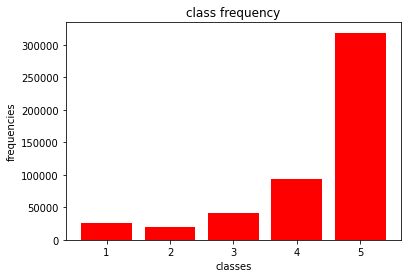

In [23]:
#un balanced dataset
y = [len(df_one.index),len(df_two.index),len(df_three.index),len(df_four.index),len(df_five.index)]
x = [1,2,3,4,5]
plt.bar(x,y,color='red',label='data-balance')
plt.title('class frequency')
plt.xlabel('classes')
plt.ylabel('frequencies')
plt.show()

In [24]:
#taking 20k from each review
sample = 20000
df = pd.concat([df_five[:sample],df_four[:sample],df_three[:sample],df_two[:sample],df_one[:sample]])

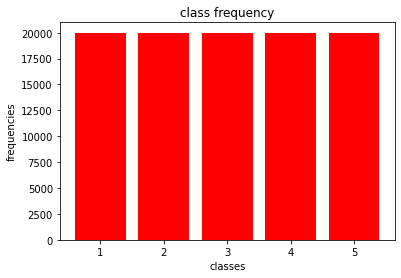

In [25]:
#balance the number dataset for same number of review for each rating
df_five = df[df['star_rating']==5]
df_four = df[df['star_rating']==4]
df_three = df[df['star_rating']==3]
df_two = df[df['star_rating']==2]
df_one = df[df['star_rating']==1]
#un balanced dataset
y = [len(df_one.index),len(df_two.index),len(df_three.index),len(df_four.index),len(df_five.index)]
x = [1,2,3,4,5]
plt.bar(x,y,color='red',label='data-balance')
plt.title('class frequency')
plt.xlabel('classes')
plt.ylabel('frequencies')
plt.show()

In [26]:
#total length of the dataset
print(len(df.index))

100000


In [27]:
#scale the ratings between 0-1
df['star_rating'] = df['star_rating']/5

In [28]:
df.head(5)

,review,star_rating
215329,une perle à écouter sans avoir besoin d avoir ...,1.0
19447,trés bien mon frère a adoré cool apparemment ...,1.0
1004412,this film blew me away and i not even fan of ...,1.0
187281,youpi vivement octobre pour m offrir ce coffr...,1.0
208816,complet de très bonne qualité et suffisant pou...,1.0


In [29]:
#shuffle the dataset again
df = sklearn.utils.shuffle(df)
df.head(10)

,review,star_rating
1059547,disappointing i had this as a sample then acc...,0.2
1220190,origin of the dark knight this film could have...,0.4
866978,absolutely fantastic best book i ve read in ...,1.0
119482,batterie hs au bout de 5 mois je suis très déç...,0.2
120960,rihanna christina alicia et les autres rihann...,0.2
10010,du pur bonheur dommage du format 4 3 pour le ...,0.8
119452,grosse deception ne pas acheter cet album pou...,0.4
100091,bon film d action un peu dans la lignée de cer...,0.8
752237,one star not very good,0.2
204613,on passe devant un film sans grand interet un ...,0.4


In [30]:
#save the transformed dataset
import pickle

df.to_pickle("./dataset.pkl")

In [31]:
#sepearate the dataframe into text reviews and ratings.
VOCAB_SIZE = 50000
with strategy.scope():
    encoder = tf.keras.layers.TextVectorization(max_tokens=VOCAB_SIZE)

In [32]:
#adap the vocabulary on the data-set
X = df['review'].map(lambda x:str(x))

In [33]:
print(type(X.values))
print(X.values.shape)
print(X.values.dtype)
X_val = X.values
print(X_val[:3])

<class 'numpy.ndarray'>
(100000,)
object
['disappointing i had this as a sample  then accidentally bought it  early kindle days  i just could not get into it  even though i tried for several days '
 'origin of the dark knight this film could have really done with tim burton being back in the director s chair  this prequel to  batman  doesn t have any of the gothic feel that made the original film so enjoyable  the elaborate architecture has gone to be replaced by generic skyscrapers  it just doesn t feel like it is set before the events in batman     the scenes set in the asian mountains drag on far too long and only add a minimal amount to the plot  but i found it interesting that bruce wayne went to such lengths to  understand  the criminals that he longs to bring to justice     if you have read the comic books regarding the origins of batman then the fear of bats and death of bruce wayne s parents is nothing new  but i guess this film was not for the avid comic book fans but average

In [34]:
encoder.adapt(X_val)

In [35]:
#check the vocabulary
vocab = np.array(encoder.get_vocabulary())
print(vocab[:20])

['' '[UNK]' 'the' 'de' 'a' 'br' 'and' 'le' 'et' 'to' 'eacute' 'of' 'la'
 'est' 'i' 'un' 'it' 'l' 'd' 'is']


In [36]:
#check the encoding functionality
example = X_val[:3]
encoded_example = encoder(example).numpy()
print(example)
print(encoded_example)

['disappointing i had this as a sample  then accidentally bought it  early kindle days  i just could not get into it  even though i tried for several days '
 'origin of the dark knight this film could have really done with tim burton being back in the director s chair  this prequel to  batman  doesn t have any of the gothic feel that made the original film so enjoyable  the elaborate architecture has gone to be replaced by generic skyscrapers  it just doesn t feel like it is set before the events in batman     the scenes set in the asian mountains drag on far too long and only add a minimal amount to the plot  but i found it interesting that bruce wayne went to such lengths to  understand  the criminals that he longs to bring to justice     if you have read the comic books regarding the origins of batman then the fear of bats and death of bruce wayne s parents is nothing new  but i guess this film was not for the avid comic book fans but average movie goers     i don t feel i have lear

In [37]:
#find the avg feature vector size for input.
df['word_list'] = df['review'].map(lambda x:str(x).split())

In [38]:
df['word_len'] = df['word_list'].map(lambda x:len(x))

In [39]:
#check the dataset
df.head(10)

,review,star_rating,word_list,word_len
1059547,disappointing i had this as a sample then acc...,0.2,"[disappointing, i, had, this, as, a, sample, t...",28
1220190,origin of the dark knight this film could have...,0.4,"[origin, of, the, dark, knight, this, film, co...",199
866978,absolutely fantastic best book i ve read in ...,1.0,"[absolutely, fantastic, best, book, i, ve, rea...",55
119482,batterie hs au bout de 5 mois je suis très déç...,0.2,"[batterie, hs, au, bout, de, 5, mois, je, suis...",34
120960,rihanna christina alicia et les autres rihann...,0.2,"[rihanna, christina, alicia, et, les, autres, ...",249
10010,du pur bonheur dommage du format 4 3 pour le ...,0.8,"[du, pur, bonheur, dommage, du, format, 4, 3, ...",30
119452,grosse deception ne pas acheter cet album pou...,0.4,"[grosse, deception, ne, pas, acheter, cet, alb...",364
100091,bon film d action un peu dans la lignée de cer...,0.8,"[bon, film, d, action, un, peu, dans, la, lign...",50
752237,one star not very good,0.2,"[one, star, not, very, good]",5
204613,on passe devant un film sans grand interet un ...,0.4,"[on, passe, devant, un, film, sans, grand, int...",44


In [40]:
#get the ratio of reviews having <512 words.
ratio = len(df[df['word_len']<512].index)/100000
print(ratio)

0.97729


In [41]:
df['word_len'].mean()

96.47764

In [42]:
#define the first bLSTM + dense
with strategy.scope():
    rnn_model = tf.keras.Sequential([
        encoder,
        tf.keras.layers.Embedding(
            input_dim=len(encoder.get_vocabulary()),
            output_dim=128,
            # Use masking to handle the variable sequence lengths
            mask_zero=True),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128,name='LSTM_layer_1')),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(5,activation='softmax')
    ])
    

    rnn_model.compile(optimizer='adam',
                  loss=tf.keras.losses.CategoricalCrossentropy(),
                  metrics=['accuracy'])



INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


In [43]:
#print model summary
rnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, None)             0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, None, 128)         6400000   
                                                                 
 bidirectional (Bidirectiona  (None, 256)              263168    
 l)                                                              
                                                                 
 dense (Dense)               (None, 128)               32896     
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 5)                 3

In [44]:
#test the model on sample data
rnn_model.predict(example)

Instructions for updating:
use `experimental_local_results` instead.


array([[0.20205891, 0.19891825, 0.199266  , 0.20050146, 0.19925536],
       [0.20213494, 0.19922061, 0.20053123, 0.19970138, 0.19841179],
       [0.20046923, 0.2000811 , 0.19987792, 0.19913758, 0.20043418]],
      dtype=float32)

In [45]:
#define the target values Y
Y = df["star_rating"].values
Y = Y.reshape(-1,1)

#onhot encoding
from sklearn.preprocessing import OneHotEncoder

one_hot_encoder = OneHotEncoder(handle_unknown='ignore')
Y=one_hot_encoder.fit_transform(Y)
Y=Y.toarray()

In [46]:
print(type(Y))
print(Y.shape)
print(Y.dtype)

<class 'numpy.ndarray'>
(100000, 5)
float64


In [47]:
#save the model for future use
import pickle
f1 = open('features.pkl','wb')
f2 = open('labels.pkl','wb')
pickle.dump(X,f1)
pickle.dump(Y,f2)
f1.close()
f2.close()


In [48]:
#split the traingin and testing data (80% for training) (20% for testing)
X_train = X_val[:80000]
Y_train = Y[:80000]

X_test = X_val[80000:]
Y_test = Y[80000:]

In [49]:
#train on the training dataset using cross validation
history = rnn_model.fit(
    X_train,
    Y_train,
    epochs=3,
    batch_size=8,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)


Epoch 1/3
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:GPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:0').
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:GPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:0').
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:GPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:0').
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:GPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:0').
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:GPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:0').
INFO:tensorflow:Reduce to /job:localhost/replica:0/task

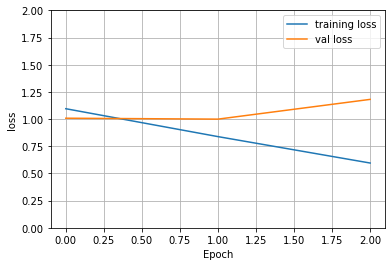

In [50]:
#plot the history
import matplotlib.pyplot as plt
def plot_loss():
  plt.plot([1.0953,0.8387,0.5957], label='training loss')
  plt.plot([1.0080,0.9995,1.1812], label='val loss')
  plt.ylim([0, 2.0])
  plt.xlabel('Epoch')
  plt.ylabel('loss')
  plt.legend()
  plt.grid(True)
plot_loss()#plot the history


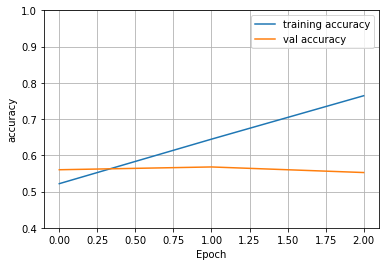

In [51]:
def plot_accuracy():
  plt.plot([0.5218,0.6446,0.7644], label='training accuracy')
  plt.plot([0.5602,0.5679,0.5525], label='val accuracy')
  plt.ylim([0.4, 1.0])
  plt.xlabel('Epoch')
  plt.ylabel('accuracy')
  plt.legend()
  plt.grid(True)

plot_accuracy()

In [52]:
#save the model for future usage
rnn_model.save('./rnn_model')


INFO:tensorflow:Assets written to: ./rnn_model/assets


INFO:tensorflow:Assets written to: ./rnn_model/assets


In [53]:
#evaluate the model of testing data
rnn_model.trainable=False

In [54]:
rnn_model.evaluate(X_test,Y_test)

625/625 [==============================] - 93s 139ms/step - loss: 1.1863 - accuracy: 0.5508


[1.1863012313842773, 0.5508000254631042]

In [55]:
#find the prediction on testing data for RNN based model
sample_X = X_test[:10]
sample_Y = Y_test[:10]

preds = rnn_model.predict(sample_X)
print(f'the predicted values ={preds}')
print(f'the real values      ={sample_Y}')


the predicted values =[[5.9563883e-02 8.0929506e-01 1.2719944e-01 3.4922054e-03 4.4934725e-04]
 [4.9572740e-02 4.5545655e-01 4.4117722e-01 4.8707318e-02 5.0860806e-03]
 [9.9600106e-01 3.6058989e-03 3.5842293e-04 3.0508104e-06 3.1627002e-05]
 [3.4538719e-03 2.0064492e-02 3.6592329e-01 5.5898142e-01 5.1576890e-02]
 [7.5487298e-01 2.3562372e-01 9.0180580e-03 3.5502858e-04 1.3028612e-04]
 [1.5272926e-01 3.6403537e-01 3.7956867e-01 8.7012902e-02 1.6653847e-02]
 [4.0711548e-02 1.8872343e-01 5.7620323e-01 1.6705705e-01 2.7304839e-02]
 [6.8398282e-02 4.8521143e-01 4.0137035e-01 4.1648071e-02 3.3718720e-03]
 [3.0462232e-01 6.5979028e-01 3.3334143e-02 1.5241152e-03 7.2908279e-04]
 [5.7120299e-01 3.1870392e-01 1.0317683e-01 4.7942847e-03 2.1219847e-03]]
the real values      =[[0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]]


In [56]:
#calculate the precision,recall,f1 score,confusion matrix for the model
from sklearn.metrics import f1_score,recall_score,precision_score,ConfusionMatrixDisplay

In [57]:
Y_preds = rnn_model.predict(X_test)
print(Y_preds.shape)

(20000, 5)


In [58]:
Y_preds_single = np.argmax(Y_preds,axis=1)
Y_real = np.argmax(Y_test,axis=1)

In [59]:
#plot the f1 score the model across different classes
f1 = f1_score(Y_real,Y_preds_single,average=None)
recall = recall_score(Y_real,Y_preds_single,average=None)
precision = precision_score(Y_real,Y_preds_single,average=None)

In [60]:
print("Weighted F1 Score : ",f1_score(Y_real,Y_preds_single,average="weighted"))
print("Weighted Recall Score : ",recall_score(Y_real,Y_preds_single,average="weighted"))
print("Weighted Precision Score : ",precision_score(Y_real,Y_preds_single,average="weighted"))

Weighted F1 Score :  0.5520338884730466
Weighted Recall Score :  0.5508
Weighted Precision Score :  0.5602864880479681


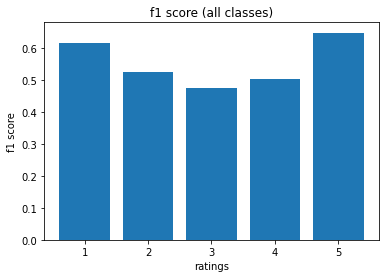

In [61]:
#plot the f1 score
x = [1,2,3,4,5]
plt.bar(x,f1,label='f1 score')
plt.title('f1 score (all classes)')
plt.xlabel('ratings')
plt.ylabel('f1 score')
plt.show()

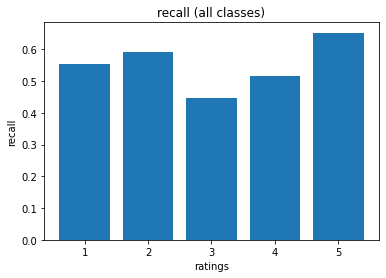

In [62]:
#plot the recall
x = [1,2,3,4,5]
plt.bar(x,recall,label='recall')
plt.title('recall (all classes)')
plt.xlabel('ratings')
plt.ylabel('recall')
plt.show()

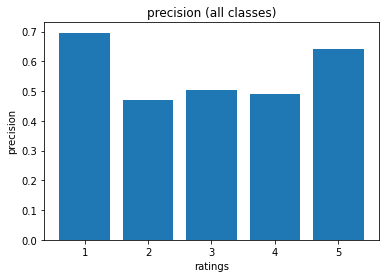

In [63]:
#precision
x = [1,2,3,4,5]
plt.bar(x,precision,label='precision')
plt.title('precision (all classes)')
plt.xlabel('ratings')
plt.ylabel('precision')
plt.show()

In [64]:
#output the confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_real,Y_preds_single)
print(cm)

[[2231 1390  232   93   91]
 [ 688 2377  654  202   93]
 [ 181  939 1798  837  281]
 [  64  251  671 2060  957]
 [  41  104  212 1003 2550]]


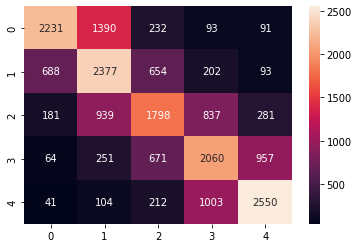

In [65]:
import seaborn as sns
sns.heatmap(cm,annot=True,fmt='g')

In [66]:
#function to test our own statements
import re

values = X_test[:3]
print(values)
preds = rnn_model.predict(values)
print("the number of stars in the process = ",np.argmax(preds,axis=1)+1)
    

['imprévisibles l un des plus grands fers de lance du heavy metal made in england verrait il sa lame s émousser   c est ce que j ai été tenté de croire la première fois que j ai écouté cet album conceptuel intégralement inspiré de la vie du célèbre  visionnaire  michel de nostredame  trop long  1h42 au compteur   trop mou  beaucoup de titres lents  et donc au final trop ennuyeux  le retour du metal god rob halford n était il qu une fumisterie  ce que m avait laissé entrevoir le précédent album  angel of retribution  trop  bof    une écoute dans ma voiture  dans ma bulle  l oreille entièrement consacrée à ce double album  a totalement inversé la tendance  j étais littéralement prisonnier de cette grande forge où étaient façonnées quelques belles lames bien affûtées  certaines étant même incrustées de perles ensorcelées  l héroïque  plague and pestilence  et la poignante  alone  d autres  plus nombreuses  moins bien aiguisées mais tout de même de qualité  puis les écoutes suivantes furen